# Results exploration and plots

## Setup

In [1]:
## append ../scripts to path
import os
import sys

# Only append if not already in path
project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
if not os.path.join(project_dir, "workflow/scripts") in sys.path:
    sys.path.append(os.path.join(project_dir, "workflow/scripts"))
print(f"Project directory: {project_dir}")

# Create figures folder if it does not exist
if not os.path.exists(os.path.join(project_dir, "workflow/notebooks/figures")):
    os.makedirs(os.path.join(project_dir, "workflow/notebooks/figures"))

Project directory: /home/bobby/projects/pci-pmi-projects


In [2]:
import logging
logger = logging.getLogger(__name__)
import pypsa
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import yaml
import cartopy.crs as ccrs

In [3]:
# Additional functions from commons
from common import add_carrier_groups, fill_missing_carriers

In [4]:
configfile = str(project_dir) + "/config/config.2030-targets-smr-0.5.yaml"
config = yaml.safe_load(open(configfile))

plottingfile = str(project_dir) + "/config/plotting.yaml"
plotting = yaml.safe_load(open(plottingfile))

prefix = config["run"]["prefix"]
scenarios = config["run"]["name"]
print(f"Prefix: {prefix}")
print(f"Scenarios: {scenarios}")

# Overwrite scenarios
scenarios = ["baseline", "scenario_a_targets_no_pipelines", "scenario_b_no_targets_no_pipelines"]

Prefix: 2030-targets-smr-0.5
Scenarios: ['baseline', 'baseline_extended', 'baseline_no_targets', 'scenario_a_targets_no_pipelines', 'scenario_b_no_targets_no_pipelines', 'targets_greenfield_pipelines']


In [5]:
# iterate through all scenarios and store all pypsa networks in a dictionary with scenarios as keys
networks = {}
for scenario in scenarios:
    print("")
    print(f"Loading network for scenario {scenario}")
    n_path = project_dir + "/results/" + prefix+ "/"+scenario+"/postnetworks/base_s_90_lv1.05___2030.nc"
    networks[scenario] = pypsa.Network(n_path)

    # Drop carriers = "none"
    networks[scenario].carriers.drop("none",inplace=True)

    # Fill missing carriers
    fill_missing_carriers(networks[scenario])

    # Add carrier groups
    add_carrier_groups(networks[scenario], plotting)    


Loading network for scenario baseline


INFO:pypsa.io:Imported network base_s_90_lv1.05___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores



Loading network for scenario scenario_a_targets_no_pipelines


INFO:pypsa.io:Imported network base_s_90_lv1.05___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores



Loading network for scenario scenario_b_no_targets_no_pipelines


INFO:pypsa.io:Imported network base_s_90_lv1.05___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


## PCI/PMI projects

In [6]:
regions_onshore = gpd.read_file("data/resources/regions_onshore_base_s_90.geojson")

links_hydrogen_pipeline = gpd.read_file("data/resources/pci-pmi-projects/cleaned/links_hydrogen_pipeline.geojson")
links_co2_pipeline = gpd.read_file("data/resources/pci-pmi-projects/cleaned/links_co2_pipeline.geojson")

stores_co2 = gpd.read_file("data/resources/pci-pmi-projects/cleaned/stores_co2.geojson")
stores_hydrogen = gpd.read_file("data/resources/pci-pmi-projects/cleaned/stores_hydrogen.geojson")

/tmp/ipykernel_132922/2581600724.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


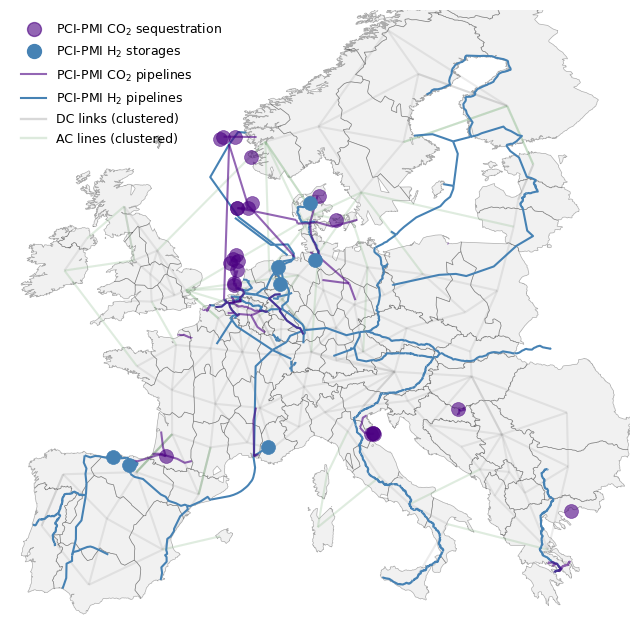

In [7]:
crs = ccrs.EqualEarth()
titlesize = 11
fontsize = 9

color_hydrogen = "steelblue"
color_co2 = "indigo"

fig, ax = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={'projection': crs})

# Add regions
regions_onshore.to_crs(crs.proj4_init).plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.3)

n = networks[scenarios[0]].copy()
n.links = n.links[n.links.carrier=="DC"]
n.plot(ax=ax, bus_sizes=0, link_widths=1.5, line_widths=1.5, line_alpha=0.15, link_alpha=0.15, color_geomap=False, line_colors="grey", link_colors="darkseagreen")

# Add hydrogen pipelines
links_hydrogen_pipeline.to_crs(crs.proj4_init).plot(ax=ax, color=color_hydrogen, linewidth=1.5, alpha=1, zorder=10)

# Add CO2 pipelines
links_co2_pipeline.to_crs(crs.proj4_init).plot(ax=ax, color=color_co2, linewidth=1.5, alpha=0.6, zorder=10)

# Add stores
stores_co2.to_crs(crs.proj4_init).plot(ax=ax, color=color_co2, edgecolor=None, linewidth=0.5, alpha=0.6, zorder=20, markersize=100)
stores_hydrogen.to_crs(crs.proj4_init).plot(ax=ax, color=color_hydrogen, edgecolor=None, linewidth=0.5, alpha=1, zorder=20, markersize=100)

# Add legend
# Create a legend for the pipelines
legend_ac_lines = plt.Line2D([0], [0], color="grey", linewidth=1.7, alpha=0.3)
legend_dc_links = plt.Line2D([0], [0], color="darkseagreen", linewidth=1.7, alpha=0.3)
legend_links_hydrogen = plt.Line2D([0], [0], color=color_hydrogen, linewidth=1.5, alpha=1)
legend_links_co2 = plt.Line2D([0], [0], color=color_co2, linewidth=1.5, alpha=0.6)
legend_stores_hydrogen = plt.Line2D([0], [0], marker="o", linewidth=0, color=color_hydrogen, markersize=10, alpha=1)
legend_stores_co2 = plt.Line2D([0], [0], marker="o", linewidth=0, color=color_co2, markersize=10, alpha=0.6)

name_ac_lines = "AC lines (clustered)"
name_dc_links = "DC links (clustered)"
name_links_hydrogen = "PCI-PMI H$_2$ pipelines"
name_links_co2 = "PCI-PMI CO$_2$ pipelines"
name_stores_hydrogen = "PCI-PMI H$_2$ storages"
name_stores_co2 = "PCI-PMI CO$_2$ sequestration"

# Add legend with border set to none
ax.legend(
    [
        legend_stores_co2,
        legend_stores_hydrogen, 
        legend_links_co2, 
        legend_links_hydrogen, 
        legend_ac_lines, 
        legend_dc_links,
    ], 
    [
        name_stores_co2,
        name_stores_hydrogen, 
        name_links_co2, 
        name_links_hydrogen, 
        name_dc_links,
        name_ac_lines,        
    ], 
    loc="upper left", fontsize=fontsize, frameon=False
)
# Add title
# ax.set_title("Clustered high-voltage grid and PCI-PMI CO$_2$-H$_2$ infrastructure", fontsize=titlesize)

# Save figure
fig.savefig("figures/pci_pmi_projects_map.pdf", bbox_inches="tight")

fig.show()

## Model results

In [8]:
df_overview = pd.DataFrame(columns=["objective_bnEUR"])
for scenario in scenarios:
    n = networks[scenario]
    # Objective
    df_overview.loc[scenario] = round(n.objective/1e9,1)

    # CO2 sequestered
    idx_co2_sequestered = n.stores[n.stores.carrier == "co2 sequestered"].index
    co2_sequestered = n.stores_t.e.loc[n.snapshots[-1], idx_co2_sequestered].sum()
    df_overview.loc[scenario, "co2_sequestered_Mt"] = round(co2_sequestered/1e6,1)

    # Electrolysers installed
    idx_electrolysers = n.links[n.links.carrier == "H2 Electrolysis"].index
    electrolysers_installed = n.links.p_nom_opt.loc[idx_electrolysers].sum()
    df_overview.loc[scenario, "electrolysers_installed_GW"] = round(electrolysers_installed/1e3,1)

    # Hydrogen produced
    idx_electrolysers = n.links[n.links.carrier == "H2 Electrolysis"].index
    h2_produced_mwh = (n.links_t.p1.loc[:,idx_electrolysers].T.sum()*n.snapshot_weightings["generators"]).sum()*(-1)
    df_overview.loc[scenario, "h2_produced_TWh"] = round(h2_produced_mwh/1e6,1)
    h2_produced_t = h2_produced_mwh / 33.33 # 33.33 MWh/t
    df_overview.loc[scenario, "h2_produced_Mt"] = round(h2_produced_t/1e6,1)

    # Electrolyser FLH
    idx_electrolysers = n.links[n.links.carrier == "H2 Electrolysis"].index
    electrolysers_flh = h2_produced_mwh / electrolysers_installed
    df_overview.loc[scenario, "electrolysers_flh"] = round(electrolysers_flh,1)

    # Total system costs
    system_costs = n.statistics.capex().sum() + n.statistics.opex().sum()
    df_overview.loc[scenario, "system_costs_bnEUR"] = round(system_costs/1e9,1)

    # System costs without installed capacities
    system_costs_no_capacities = n.statistics.capex().sum() + n.statistics.opex().sum() - n.statistics.installed_capex().sum()
    df_overview.loc[scenario, "system_costs_w/o_installed_bnEUR"] = round(system_costs_no_capacities/1e9,1)

    # OPEX
    opex = n.statistics.opex().sum()
    df_overview.loc[scenario, "opex_bnEUR"] = round(opex/1e9,1)

df_overview = df_overview.T
df_overview

,baseline,scenario_a_targets_no_pipelines,scenario_b_no_targets_no_pipelines
objective_bnEUR,600.3,605.8,583.4
co2_sequestered_Mt,50.0,50.0,21.4
electrolysers_installed_GW,71.7,69.1,0.0
h2_produced_TWh,333.3,333.3,0.0
h2_produced_Mt,10.0,10.0,0.0
electrolysers_flh,4650.7,4820.2,2002.3
system_costs_bnEUR,812.8,782.3,759.8
system_costs_w/o_installed_bnEUR,600.3,605.8,583.4
opex_bnEUR,363.2,364.0,361.3


## Plots

### System costs

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

alpha = 1
region_alpha = 0.8

df_system_costs = {}

for scenario, n in networks.items():
    capex = n.statistics.capex(nice_names=False)
    opex = n.statistics.opex(aggregate_time="sum", nice_names=False)

    costs = capex.add(opex, fill_value=0)
    costs = costs.droplevel(0)[lambda x: x > 0]
    costs = costs.groupby(costs.index).sum()

    key = n.meta["wildcards"]["run"]
    df_system_costs[key] = costs

df_system_costs = pd.concat(df_system_costs, axis=1)
df_system_costs.fillna(0, inplace=True)

groups = networks[scenarios[0]].carriers.group
group_dict = dict(zip(groups.index, groups))
grouped_system_costs = df_system_costs.groupby(group_dict).sum()

# add column color
grouped_system_costs["color"] = grouped_system_costs.index.map(lambda x: plotting["plotting"]["technology_group_colors"][x])

grouped_system_costs

,baseline,scenario_a_targets_no_pipelines,scenario_b_no_targets_no_pipelines,color
carrier,,,,
Battery Infrastructure,4.200673e+08,8.642214e+08,1.562409e+09,#ace37f
Bioenergy,3.840019e+10,3.921703e+10,4.018259e+10,#baa741
Boiler,5.057535e+10,5.038148e+10,4.968627e+10,#db6a25
CO$_2$ Infrastructure,2.845467e+10,5.636887e+08,2.164606e+08,#cc99ff
Carbon Capt. at Point Sources,4.019483e+09,5.942884e+09,2.460132e+09,#f29dae
Coal,4.595409e+09,4.239110e+09,4.815218e+09,#545454
DAC,1.835006e+04,6.628054e+08,1.717453e+04,#ff5270
Electricity Grid,3.997419e+10,3.913847e+10,3.994861e+10,#97ad8c
Electrolysis,1.353022e+10,1.305448e+10,9.787382e+03,#b3e6ff


In [10]:
# Whats inside other?
# df_system_costs.loc[list(set(groups[groups.values=="Other"].index).intersection(set(df_system_costs.index)))]

In [11]:
rename_scenarios = {
    'baseline': 'Base (All targets)',
    'baseline_extended': 'Base ext. (All targets)',
    'baseline_no_targets': 'Base (Emission target only)',
    'scenario_a_targets_no_pipelines': 'A. PCI-PMI Delay (All targets)', 
    'scenario_b_no_targets_no_pipelines': 'B. PCI-PMI Delay (Emission target only)',
    'targets_greenfield_pipelines': 'Greenfield Pipelines (All targets)',
}

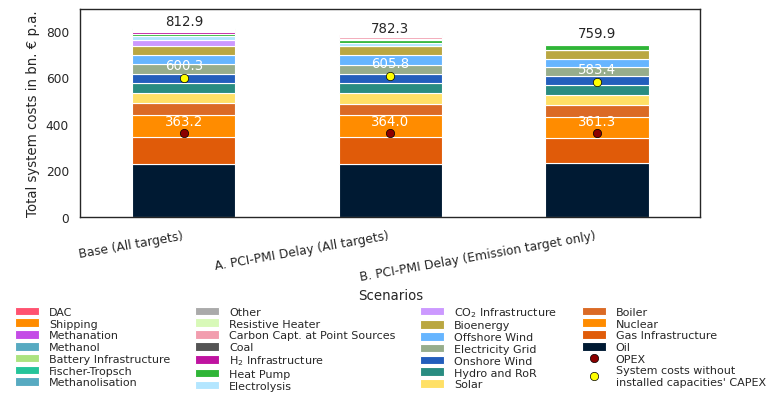

In [12]:
# Stacked bar plot
norm = 1e9
unit = "bn. € p.a."
colors = plotting["plotting"]["technology_group_colors"]

# Apply Seaborn style
sns.set_style("white")  # You can choose 'whitegrid', 'darkgrid', 'white', 'dark', or 'ticks'
sns.set_context("paper")  # Options: 'paper', 'notebook', 'talk', 'poster'
plt.rcParams['font.family'] = 'sans-serif'

plot_df = grouped_system_costs.sort_values(by="baseline", ascending=False).drop(columns="color").div(norm)
plot_df.rename(columns=rename_scenarios, inplace=True)

# Assuming 'grouped' is your DataFrame and 'colors' is your list of colors
ax = plot_df.T.plot.bar(stacked=True, color=colors, figsize=(8, 2.7))

# Add sum of total system costs on top of bars 
for i in range(len(plot_df.columns)):
    ax.text(i, plot_df.iloc[:,i].sum(), f"{round(plot_df.iloc[:,i].sum(),1)}", ha='center', va='bottom')

# Add total sum
max_value = plot_df.sum().max()

# Plot settings
ax.set_title("")
ax.set_xlabel("Scenarios")
ax.set_ylabel(f"Total system costs in {unit}")
ax.set_ylim(0, max_value*1.1)
# Rotate x-axis labels
ax.set_xticks(range(len(plot_df.columns)))
ax.set_xticklabels(plot_df.columns)

# Overlay system costs without installed capacities
df_overview.rename(columns=rename_scenarios).loc["system_costs_w/o_installed_bnEUR"].mul(1e9).div(norm).plot(
    ax=ax, marker="o", linestyle="", color="yellow", 
    markeredgecolor="black", markeredgewidth=0.5, markersize=6,
    label="System costs without\ninstalled capacities' CAPEX",
    zorder = 5  # Higher zorder to appear on top
)
# Add value on top
for i, value in enumerate(df_overview.loc["system_costs_w/o_installed_bnEUR"]):
    ax.text(i, value+24, f"{round(value,1)}", ha='center', va='bottom', color="white", )

# OPEX
df_overview.rename(columns=rename_scenarios).loc["opex_bnEUR"].mul(1e9).div(norm).plot(
    ax=ax, marker="o", linestyle="", color="darkred", 
    markeredgecolor="black", markeredgewidth=0.5, markersize=6,
    label="OPEX",
    zorder=5  # Higher zorder to appear on top
)
# Add value on top
for i, value in enumerate(df_overview.loc["opex_bnEUR"]):
    ax.text(i, value+20, f"{round(value,1)}", ha='center', va='bottom', color="white", )

# Legend, reverse order
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, labelspacing=0.1)
ax.legend(handles[::-1], labels[::-1], loc='upper center', bbox_to_anchor=(0.5, -0.37), frameon=False, labelspacing=0.1, ncol=4)
plt.setp(ax.get_legend().get_texts(), fontsize='8')

ax.tick_params(axis='x', rotation=10)
# Offset x ticks to the left
ax.set_xticklabels(ax.get_xticklabels(), ha="right")

plt.savefig("figures/system_costs.pdf", bbox_inches='tight')
plt.show()

### Hydrogen balance

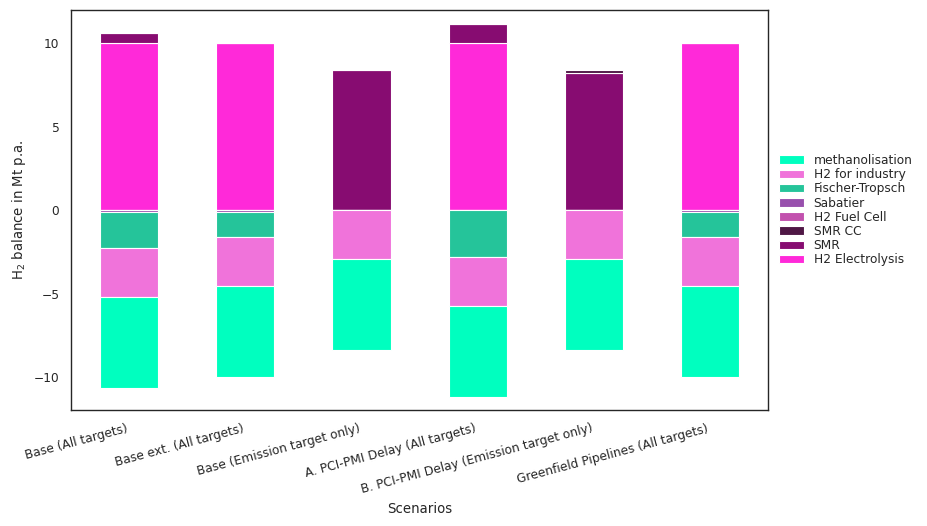

In [108]:
df_h2_balance = {}

for scenario, n in networks.items():
    balance = n.statistics.energy_balance(bus_carrier="H2", nice_names=False).groupby("carrier").sum()

    key = n.meta["wildcards"]["run"]
    df_h2_balance[key] = balance

df_h2_balance = pd.concat(df_h2_balance, axis=1)
df_h2_balance.fillna(0, inplace=True)

# Stacked bar plot
norm = 1e6*33.33 # MWh to Mt
unit = "Mt p.a."
colors = plotting["plotting"]["tech_colors"]

# Apply Seaborn style
sns.set_style("white")  # You can choose 'whitegrid', 'darkgrid', 'white', 'dark', or 'ticks'
sns.set_context("paper")  # Options: 'paper', 'notebook', 'talk', 'poster'
plt.rcParams['font.family'] = 'sans-serif'

plot_df = df_h2_balance.sort_values(by="baseline", ascending=False).div(norm)
plot_df.rename(columns=rename_scenarios, inplace=True)

# Assuming 'grouped' is your DataFrame and 'colors' is your list of colors
ax = plot_df.T.plot.bar(stacked=True, color=colors, figsize=(9, 5.2))


# Plot settings
ax.set_title("")
ax.set_xlabel("Scenarios")
ax.set_ylabel(f"H$_2$ balance in {unit}")
# Rotate x-axis labels
ax.set_xticks(range(len(plot_df.columns)))
ax.set_xticklabels(plot_df.columns)

# ylim to the max. of abs of all values
ax.set_ylim(-plot_df.abs().max().max()*1.2, plot_df.abs().max().max()*1.2)


# Legend, reverse order
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, labelspacing=0.1)

ax.tick_params(axis='x', rotation=15)
# Offset x ticks to the left
ax.set_xticklabels(ax.get_xticklabels(), ha="right")


plt.savefig("figures/h2_balance_all.pdf", bbox_inches='tight')
plt.show()

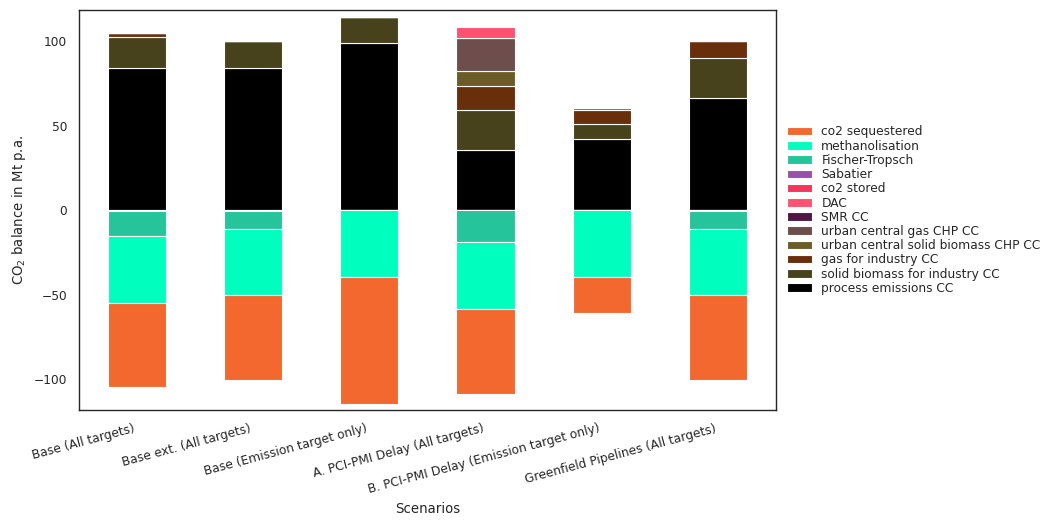

In [109]:
df_co2_stored_balance = {}

for scenario, n in networks.items():
    balance = n.statistics.energy_balance(bus_carrier="co2 stored", nice_names=False).groupby("carrier").sum()

    key = n.meta["wildcards"]["run"]
    df_co2_stored_balance[key] = balance

df_co2_stored_balance = pd.concat(df_co2_stored_balance, axis=1)
df_co2_stored_balance.fillna(0, inplace=True)

# Stacked bar plot
norm = 1e6
unit = "Mt p.a."
colors = plotting["plotting"]["tech_colors"]

# Apply Seaborn style
sns.set_style("white")  # You can choose 'whitegrid', 'darkgrid', 'white', 'dark', or 'ticks'
sns.set_context("paper")  # Options: 'paper', 'notebook', 'talk', 'poster'
plt.rcParams['font.family'] = 'sans-serif'

plot_df = df_co2_stored_balance.sort_values(by="baseline", ascending=False).div(norm)
plot_df.rename(columns=rename_scenarios, inplace=True)

# Assuming 'grouped' is your DataFrame and 'colors' is your list of colors
ax = plot_df.T.plot.bar(stacked=True, color=colors, figsize=(9, 5.2))


# Plot settings
ax.set_title("")
ax.set_xlabel("Scenarios")
ax.set_ylabel(f"CO$_2$ balance in {unit}")
# Rotate x-axis labels
ax.set_xticks(range(len(plot_df.columns)))
ax.set_xticklabels(plot_df.columns)

# ylim to the max. of abs of all values
ax.set_ylim(-plot_df.abs().max().max()*1.2, plot_df.abs().max().max()*1.2)


# Legend, reverse order
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, labelspacing=0.1)

ax.tick_params(axis='x', rotation=15)
# Offset x ticks to the left
ax.set_xticklabels(ax.get_xticklabels(), ha="right")

plt.savefig("figures/co2_stored_balance_all.pdf", bbox_inches='tight')
plt.show()

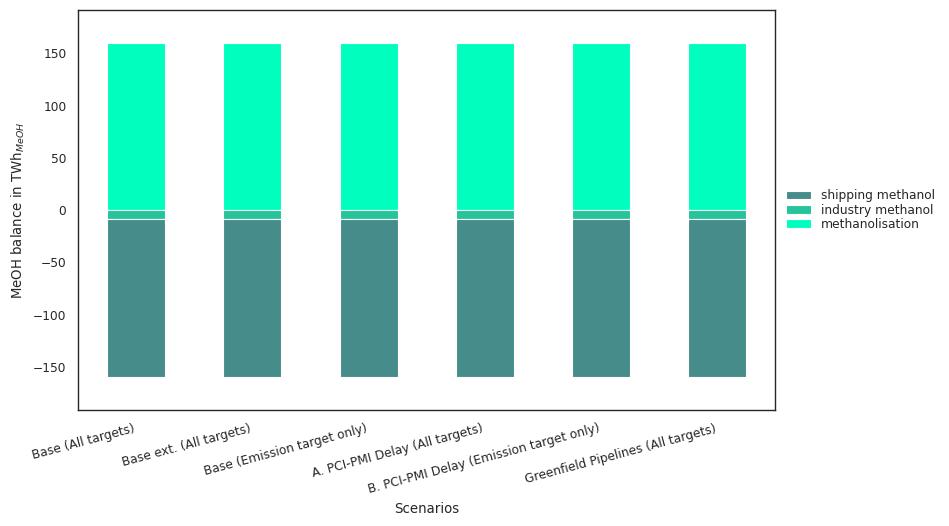

In [110]:
df_methanol_balance = {}

for scenario, n in networks.items():
    balance = n.statistics.energy_balance(bus_carrier="methanol", nice_names=False).groupby("carrier").sum()

    key = n.meta["wildcards"]["run"]
    df_methanol_balance[key] = balance

df_methanol_balance = pd.concat(df_methanol_balance, axis=1)
df_methanol_balance.fillna(0, inplace=True)

# Stacked bar plot
norm = 1e6
unit = "TWh$_{MeOH}$"
colors = plotting["plotting"]["tech_colors"]

# Apply Seaborn style
sns.set_style("white")  # You can choose 'whitegrid', 'darkgrid', 'white', 'dark', or 'ticks'
sns.set_context("paper")  # Options: 'paper', 'notebook', 'talk', 'poster'
plt.rcParams['font.family'] = 'sans-serif'

plot_df = df_methanol_balance.sort_values(by="baseline", ascending=False).div(norm)
plot_df.rename(columns=rename_scenarios, inplace=True)

# Assuming 'grouped' is your DataFrame and 'colors' is your list of colors
ax = plot_df.T.plot.bar(stacked=True, color=colors, figsize=(9, 5.2))


# Plot settings
ax.set_title("")
ax.set_xlabel("Scenarios")
ax.set_ylabel(f"MeOH balance in {unit}")
# Rotate x-axis labels
ax.set_xticks(range(len(plot_df.columns)))
ax.set_xticklabels(plot_df.columns)

# ylim to the max. of abs of all values
ax.set_ylim(-plot_df.abs().max().max()*1.2, plot_df.abs().max().max()*1.2)


# Legend, reverse order
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, labelspacing=0.1)

ax.tick_params(axis='x', rotation=15)
# Offset x ticks to the left
ax.set_xticklabels(ax.get_xticklabels(), ha="right")

plt.savefig("figures/methanol_balance_all.pdf", bbox_inches='tight')

### Other

In [16]:
n0 = networks["scenario_b_no_targets_no_pipelines"]

In [17]:
n0.statistics.energy_balance(bus_carrier="methanol")

component  carrier            bus_carrier
Link       industry methanol  methanol      -8.750000e+06
           shipping methanol  methanol      -1.508909e+08
           methanolisation    methanol       1.596409e+08
dtype: float64

In [17]:
scenarios[3]

'scenario_b_no_targets_no_pipelines'

In [25]:
n.statistics.energy_balance(bus_carrier="methanol")

component  carrier            bus_carrier
Link       industry methanol  methanol      -8.750000e+06
           shipping methanol  methanol      -1.508909e+08
           methanolisation    methanol       1.596409e+08
dtype: float64

In [20]:
n = networks[scenarios[3]]

In [24]:
n.statistics.market_value(bus_carrier="H2")

component  carrier        
Link       Fischer-Tropsch            NaN
           H2 Electrolysis      63.970972
           H2 Fuel Cell               NaN
           SMR                  66.711101
           SMR CC               55.415145
           Sabatier                   NaN
           methanolisation            NaN
Load       H2 for industry   -4585.355489
Store      H2 Store              5.722284
dtype: float64

In [19]:
networks[scenarios[3]].statistics.energy_balance(bus_carrier="co2")


component  carrier                             bus_carrier
Link       process emissions                   co2            1.968533e+08
           process emissions CC                co2            5.696748e+05
           urban central gas CHP               co2            5.850492e+07
           urban central gas CHP CC            co2            9.916640e+00
           urban central solid biomass CHP CC  co2           -4.321869e+02
           DAC                                 co2           -7.695826e+01
           Open-Cycle Gas                      co2            4.977673e+06
           SMR                                 co2            2.339418e+07
           SMR CC                              co2            5.448553e+06
           agriculture machinery oil           co2            2.644213e+07
           biogas to gas                       co2           -1.292665e+07
           coal for industry                   co2            1.146064e+08
           gas for industry              

In [ ]:
# n.statistics.withdrawal(bus_carrier="oil")
# n.statistics.sppply(bus_carrier="oil")

component  carrier                  
Link       agriculture machinery oil    1.028476e+08
           kerosene for aviation        7.439070e+08
           land transport oil           2.210376e+09
           naphtha for industry         7.769400e+08
           shipping oil                 4.048906e+08
Store      oil                          1.008664e+02
dtype: float64

In [13]:
n.statistics.energy_balance(bus_carrier="methanol")

component  carrier            bus_carrier
Link       industry methanol  methanol      -8.750000e+06
           shipping methanol  methanol      -1.508909e+08
           methanolisation    methanol       1.596409e+08
dtype: float64

In [16]:
n1 = networks['scenario_b_no_targets_no_pipelines']
n2 = networks['scenario_b_no_targets_no_pipelines_smr_0.5_capture_rate']

In [17]:
n1.statistics.energy_balance(bus_carrier="co2 sequestered")

component  carrier          bus_carrier    
Link       co2 sequestered  co2 sequestered    2.820490e+07
Store      co2 sequestered  co2 sequestered   -2.820490e+07
dtype: float64

In [18]:
n2.statistics.energy_balance(bus_carrier="co2 sequestered")

component  carrier          bus_carrier    
Link       co2 sequestered  co2 sequestered    2.143082e+07
Store      co2 sequestered  co2 sequestered   -2.143082e+07
dtype: float64